In [1]:
import os
import json
import time
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import geopandas as gpd

import dask.array as da
from datetime import datetime

import cartopy.crs as ccrs

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from playsound import playsound
from multiprocessing import Pool

from scipy.optimize import differential_evolution

import psutil
from joblib import Parallel, delayed

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_downscale as ART_down
from function import ART_preprocessing as ART_pre
from function import DOWN_raw

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [2]:
product, time_reso, cor_method = 'CMORPH', '3h', 'spearman'
# product, time_reso, cor_method = 'ERA5', '3h', 'pearson'
# product, time_reso = 'GSMaP', '3h', 'pearson'
# product, time_reso = 'MSWEP', '3h', 'pearson'
# product, time_reso, cor_method = 'IMERG', '1dy', 'pearson'
# product, time_reso = 'IMERG', '3h', 'pearson'
# product, time_reso, cor_method = 'PERSIANN', '1dy', 'spearman'
# product, time_reso = 'SM2RAIN', '1dy' # Dont works

yy_s, yy_e = 2002, 2012
years_num = yy_e - yy_s + 1

# # Test area 1
# lon_min, lon_max, lat_min, lat_max = 11, 11.5, 46, 46.5
# # Test area 2
lon_min, lon_max, lat_min, lat_max, area = 11, 12.5, 45, 46.5, 'TEST'
# # Veneto
# lon_min, lon_max, lat_min, lat_max, area = 10.5, 13.5, 44.5, 47, 'VENETO'

In [3]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [4]:
json_read = f'../json/{product}_{time_reso}.json'

if os.path.exists(json_read):
    with open (json_read) as f:
        param = json.load(f)
else:
    raise SystemExit(f"File not found: {json_read}")

NEIBHR = 2*param['npix']+1

print(f'Read json file   : {json_read.split('/')[-1]}')
print(f'ACF function     : {param['acf']}')
print(f'Number of threads: {param['BETA_cores']}')
print(f'Neighborhood area: {NEIBHR}x{NEIBHR}')
print(f'Opt method: {param['opt_method']}')
print()

Read json file   : CMORPH_3h.json
ACF function     : str
Number of threads: 25
Neighborhood area: 3x3
Opt method: lbfgsb



In [5]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy')

In [6]:
print(f'Reading data: {param['file']}')
if product == 'SM2RAIN':
    dir_data = os.path.join(dir_base,'Satellite',product,'ASCAT',time_reso,param['file'])
else:
    dir_data = os.path.join(dir_base,'Satellite',product,time_reso,param['file'])

PRE_data = xr.open_dataset(dir_data)
PRE_data = PRE_data.sel(time=PRE_data.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))

if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN' or product == 'ERA5' or product == 'GSMaP':
    PRE_data = PRE_data.sel(lat=slice(lat_max+1, lat_min-1), lon=slice(lon_min-1, lon_max+1))
else:
    PRE_data = PRE_data.sel(lat=slice(lat_min-1, lat_max+1), lon=slice(lon_min-1, lon_max+1))

lats = PRE_data['lat'].data
lons = PRE_data['lon'].data

lon2d, lat2d = np.meshgrid(lons, lats)

nlon = np.size(lons)
nlat = np.size(lats)
ntime = len(PRE_data['time'])

year_vector = np.unique(pd.to_datetime(PRE_data['time']).year)

PRE_data = PRE_data.where(PRE_data >= 0)  # Reemplaza valores negativos con NaN

PRE_1dy = PRE_data.resample(time ='D').sum(dim='time', skipna=False)

PRE_data

Reading data: CMORPH_Italy_3hr_1998_01_01_2023_12_31.nc


<xarray.Dataset> Size: 25MB
Dimensions:  (time: 32144, lat: 14, lon: 14)
Coordinates:
  * lat      (lat) float32 56B 44.12 44.38 44.62 44.88 ... 46.88 47.12 47.38
  * lon      (lon) float32 56B 10.12 10.38 10.62 10.88 ... 12.88 13.12 13.38
  * time     (time) datetime64[ns] 257kB 2002-01-01 ... 2012-12-31T21:00:00
Data variables:
    PRE      (time, lat, lon) float32 25MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    description:  CMORPH hourly data for Italy region in 1998 to 2023

In [7]:
# Extracting lat and lon points for Study area (VENETO)
if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN' or product == 'ERA5' or product == 'GSMaP':
    PRE_veneto = PRE_data.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))
else:
    PRE_veneto = PRE_data.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

lat_ref = PRE_veneto.lat.values
lon_ref = PRE_veneto.lon.values

ndices_lat = np.where(np.isin(lats, lat_ref))[0]
ndices_lon = np.where(np.isin(lons, lon_ref))[0]

lon2d_ref, lat2d_ref = np.meshgrid(lon_ref, lat_ref)

del PRE_veneto

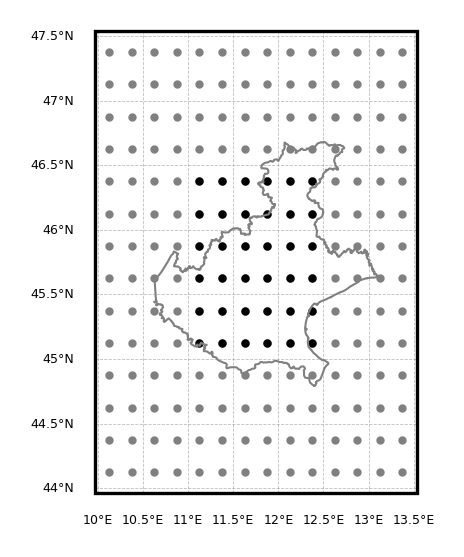

In [8]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,2),dpi=300)
gs = gridspec.GridSpec(1,1)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10, edgecolor='grey')
ax1.scatter(lon2d, lat2d, s=1, c='grey')
ax1.scatter(lon2d_ref, lat2d_ref, s=1, c='k')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

In [ ]:
def downscale_clear(DATA_3h,la,lo,param):
    
    lat_c = lat_ref[la]
    lon_c = lon_ref[lo]

    Tr = np.array([5, 10, 20, 50, 100, 200])

    # eps = 1e-4
    # solat = lat_c - buffer + eps
    # nolat = lat_c + buffer + eps
    # ealon = lon_c + buffer + eps
    # welon = lon_c - buffer + eps
    # bcond = np.logical_and(
    #             np.logical_and( DATA_3h.lat > solat, DATA_3h.lat < nolat),
    #             np.logical_and( DATA_3h.lon > welon, DATA_3h.lon < ealon))
    # box_3h = DATA_3h.where(bcond, drop = True).load()
    
    box_3h = DOWN_raw.create_box_v2(DATA_3h, lat_c, lon_c, param['npix'])
    
    if box_3h.shape[0] !=3 or box_3h.shape[1] !=3:
    # if box_3h.shape[0] !=5 or box_3h.shape[1] !=5:
        print(lat_c,lon_c,box_3h.shape)

    downres = DOWN_raw.downscale(box_3h, Tr, thresh=1.0, L0=0.0001, 
                                cor_method=cor_method, toll=0.002,
                                acf=param['acf'], save_yearly=True,
                                maxmiss=40, clat=lat_c, clon=lon_c,
                                opt_method=param['opt_method'], plot=False)

    return downres

In [10]:
PRE_data_T = PRE_data.transpose('lon', 'lat', 'time')
time_vector_dt = pd.to_datetime(PRE_data_T['PRE']['time'].values)
DATA_3h = xr.DataArray(PRE_data_T['PRE'],  coords={
                            'lon':PRE_data_T['lon'].values, 
                            'lat':PRE_data_T['lat'].values, 
                            'time':time_vector_dt},
                            dims=('lon', 'lat', 'time'))

In [11]:
npix = 3 #3x3
# npix = 4 # IMERG 5x5

if product == 'CMORPH':
    buffer = 0.50*npix*0.25
elif product == 'ERA5':
    buffer = 0.50*npix*0.25
elif product == 'IMERG':
    buffer = 0.25*npix*0.25
elif product == 'MSWEP':
    buffer = 0.25*npix*0.25
elif product == 'GSMaP':
    buffer = 0.25*npix*0.25
elif product == 'PERSIANN':
    buffer = 0.50*npix*0.25
else:
    buffer = 0.25*npix*0.25

In [12]:
print(f'ACF: {param['acf']}')
\
def compute_for_point(args):
    DATA_3h, la, lo, param = args
    return la, lo, downscale_clear(DATA_3h,la,lo,param)

with Pool(processes=27) as pool:
    results = pool.map(compute_for_point, [(DATA_3h,la,lo,param) for la in range(len(lat_ref)) for lo in range(len(lon_ref))])

ACF: str
Downscaling Intermittency
Downscaling Intermittency
Downscaling Intermittency
Downscaling Intermittency
Downscaling Intermittency
Downscaling Intermittency
Downscaling Intermittency
Downscaling Intermittency
Downscaling Intermittency
Downscaling Intermittency
Downscaling Intermittency
Downscaling Intermittency
Downscaling Intermittency
Downscaling Intermittency
Downscaling Intermittency
Downscaling Intermittency
Downscaling Intermittency
Downscaling IntermittencyDownscaling Intermittency

Downscaling Intermittency
Downscaling IntermittencyDownscaling Intermittency

Downscaling Intermittency
Downscaling Intermittency
Downscaling Intermittency
Downscaling Intermittency
Downscaling Intermittency
Downscaling the correlation
Computing the correlation
Downscaling the correlation
Computing the correlation
Downscaling the correlation
Computing the correlation
Downscaling the correlation
Computing the correlation
Downscaling the correlation
Computing the correlation
Downscaling the cor


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   19    f=  5.55707D-03    |proj g|=  3.42501D-03

At iterate   24    f=  1.19065D-02    |proj g|=  6.44561D-02
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate   21    f=  6.24907D-03    |proj g|=  1.40659D-03

At iterate   17    f=  9.09782D-03    |proj g|=  3.88869D-02

At iterate   19    f=  9.41602D-04    |proj g|=  5.21986D-02

At iterate   20    f=  6.76630D-03    |proj g|=  1.27603D-04

At iterate   20    f=  8.17329D-03    |proj g|=  1.87186D-02

At iterate   20    f=  2.64627D-03    |proj g|=  2.49272D-02

At iterate   25    f=  5.08783D-03    |proj g|=  4.07318D-02

At iterate   20    f=  8.51976D-04    |proj g|=  3.46663D-02

At iterate   25    f=  1.16003D-02    |proj g|=  7.65487D-02
Downscaling pdf - global Weibull parameters

At iterate   20    f=  5.55707D-03    |proj g|=  3.62303D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   28    f=  5.03359D-03    |proj g|=  3.33170D-02

At iterate   22    f=  6.54674D-03    |proj g|=  6.56241D-02

At iterate   25    f=  2.39038D-03    |proj g|=  3.12569D-02

At iterate   25    f=  7.95135D-03    |proj g|=  2.44580D-02

At iterate   29    f=  5.02570D-03    |proj g|=  4.18447D-02

At iterate   29    f=  1.11105D-02    |proj g|=  1.28208D-01

At iterate   16    f=  2.47361D-03    |proj g|=  4.02547D-05

At iterate   22    f=  1.24408D-02    |proj g|=  1.86093D-02
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate   23    f=  6.46191D-03    |proj g|=  1.03617D-01

At iterate   26    f=  7.94805D-03    |proj g|=  1.53520D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f=  1.10381D-02    |proj g|=  1.34674D-01

At iterate   28    f=  6.60263D-04    |proj g|=  4.83821D-03

At iterate   30    f=  5.00644D-03    |proj g|=  5.38333D-02

At iterate   24    f=  6.26938D-03    |proj g|=  1.19170D-01

At iterate   27    f=  7.93523D-03    |proj g|=  2.44865D-05

At iterate   26    f=  2.37904D-03    |proj g|=  1.40382D-02
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate   23    f=  1.12858D-02    |proj g|=  1.73768D-01

At iterate   31    f=  4.97936D-03    |proj g|=  1.96823D-04

At iterate   22    f=  6.24905D-03    |proj g|=  2.70065D-04

At iterate   25    f=  5.79470D-03    |proj g|=  6.42686D-02
Downscaling pdf - global Weibull parameters
Downscaling pdf - yearly Weibull parameters

At iterate   28    f=  7.91716D-03    |proj g|=  3.13737D-02

At iterate   17    f=  2.47361D-03    |proj g|=  5.01315D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluatio


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   42    f=  7.85791D-03    |proj g|=  1.23289D-04

At iterate   30    f=  5.54227D-03    |proj g|=  2.83601D-02
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate   44    f=  6.03477D-04    |proj g|=  1.75312D-02

At iterate   33    f=  2.23230D-03    |proj g|=  1.21474D-02

At iterate   45    f=  6.01028D-04    |proj g|=  1.12487D-02

At iterate   45    f=  9.95720D-03    |proj g|=  7.97240D-02

At iterate   46    f=  5.98922D-04    |proj g|=  7.58125D-03

At iterate   46    f=  4.83037D-03    |proj g|=  8.88538D-03
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate   46    f=  9.92151D-03    |proj g|=  1.00945D-01

At iterate   47    f=  5.97377D-04    |proj g|=  1.76684D-02

At iterate   43    f=  7.85721D-03    |proj g|=  5.22318D-03

At iterate   34    f=  8.15461D-03    |proj g|=  9.29722D-02

At iterate   31    f=  5.50008D-03    |proj g|=  3.83482D-02

At iterate   34    f=  2.23042D-03    |proj g|=  


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate  156    f=  1.97881D-03    |proj g|=  2.71666D+00

At iterate  157    f=  1.97880D-03    |proj g|=  4.61167D+00

At iterate  158    f=  1.97877D-03    |proj g|=  5.99709D+00

At iterate  159    f=  1.97873D-03    |proj g|=  7.84016D+00

At iterate  160    f=  1.97868D-03    |proj g|=  9.41878D+00

At iterate  161    f=  1.97860D-03    |proj g|=  1.07170D+01

At iterate  162    f=  1.97846D-03    |proj g|=  1.17600D+01

At iterate  163    f=  1.97823D-03    |proj g|=  1.22869D+01

At iterate  164    f=  1.97795D-03    |proj g|=  1.93259D+01

At iterate  165    f=  1.97671D-03    |proj g|=  6.07706D-01

At iterate  166    f=  1.97656D-03    |proj g|=  1.00138D+01

At iterate  167    f=  1.97655D-03    |proj g|=  1.14886D+01

At iterate  168    f=  1.97646D-03    |proj g|=  1.46914D+01

At iterate  169    f=  1.97638D-03    |proj g|=  1.77472D+01

At iterate  170    f=  1.97623D-03    |proj g|=  1.94617D+01

At iterate  171    f=  1.97595D-03    |proj g|=  1.96104D+01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  179    f=  1.97293D-03    |proj g|=  6.97469D-03
Downscaling pdf - global Weibull parameters
Downscaling pdf - yearly Weibull parameters

At iterate  180    f=  1.97293D-03    |proj g|=  6.97473D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2    180    379    182     0     0   6.975D-03   1.973D-03
  F =   1.9729328463404779E-003

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [15]:
Tr = np.array([5, 10, 20, 50, 100, 200])

years_num = yy_e - yy_s + 1
full_years = np.arange(yy_s, yy_e + 1)

shape = (len(lat_ref), len(lon_ref))

NYs = np.full([years_num, len(lat_ref), len(lon_ref)], np.nan)
CYs = np.full([years_num, len(lat_ref), len(lon_ref)], np.nan)
WYs = np.full([years_num, len(lat_ref), len(lon_ref)], np.nan)

NYd = np.full([years_num, len(lat_ref), len(lon_ref)], np.nan)
CYd = np.full([years_num, len(lat_ref), len(lon_ref)], np.nan)
WYd = np.full([years_num, len(lat_ref), len(lon_ref)], np.nan)

Mev_d = np.zeros((len(Tr), *shape))
Mev_s = np.zeros((len(Tr), *shape))

BETA = np.zeros([len(lat_ref), len(lon_ref)])
GAMMA = np.zeros([len(lat_ref), len(lon_ref)])

FUNVAL = np.zeros([len(lat_ref), len(lon_ref)])

for la, lo, downres in results:
    
    available_years = downres['YEARS'].astype(int) 
    indices = np.searchsorted(full_years, available_years)
    
    NYs[indices, la, lo] = downres['NYs']
    CYs[indices, la, lo] = downres['CYs']
    WYs[indices, la, lo] = downres['WYs']
    
    NYd[indices, la, lo] = downres['NYd']
    CYd[indices, la, lo] = downres['CYd']
    WYd[indices, la, lo] = downres['WYd']
    
    Mev_d[:, la, lo] = downres['mev_d']
    Mev_s[:, la, lo] = downres['mev_s']
    
    BETA[la, lo] = downres['beta']
    GAMMA[la, lo] = downres['gam_d']
    
    FUNVAL[la,lo] = downres['corr_down_funval']

In [16]:
DOWN_xr = xr.Dataset(data_vars={
                    "NYs": (("year","lat","lon"), NYs),
                    "CYs": (("year","lat","lon"), CYs),
                    "WYs": (("year","lat","lon"), WYs),
                    "Mev_s": (("Tr","lat","lon"), Mev_s),
                    "NYd": (("year","lat","lon"), NYd),
                    "CYd": (("year","lat","lon"), CYd),
                    "WYd": (("year","lat","lon"), WYd),
                    "Mev_d": (("Tr","lat","lon"), Mev_d),
                    "BETA": (("lat","lon"), BETA),
                    "GAMMA": (("lat","lon"), GAMMA),
                    "FUNVAL": (("lat","lon"), FUNVAL)
                    },
    coords={'Tr':Tr,'lat': lat_ref, 'lon': lon_ref},
    attrs=dict(description=f"Downscaling for {product} in the region bounded by longitudes {lon_min} to {lon_max} and latitudes {lat_min} to {lat_max}, using '{param['acf']}' as the acf function, '{param['thresh']} mm' threshold and box size '{npix}x{npix}'."))

DOWN_xr.NYs.attrs["units"] = "day"
DOWN_xr.NYs.attrs["long_name"] = "Number of wet days"
DOWN_xr.NYs.attrs["origname"] = "wet days"

DOWN_xr.CYs.attrs["units"] = "dimensionless"
DOWN_xr.CYs.attrs["long_name"] = "Weibull scale parameter"
DOWN_xr.CYs.attrs["origname"] = "scale"

DOWN_xr.WYs.attrs["units"] = "dimensionless"
DOWN_xr.WYs.attrs["long_name"] = "Weibull shape parameter"
DOWN_xr.WYs.attrs["origname"] = "shape"

DOWN_xr.Mev_s.attrs["units"] = "mm/day"
DOWN_xr.Mev_s.attrs["long_name"] = "Satellite Maximum Quantiles"
DOWN_xr.Mev_s.attrs["origname"] = "Satellite quantiles"

DOWN_xr.NYd.attrs["units"] = "day"
DOWN_xr.NYd.attrs["long_name"] = "Downscale Number of wet days"
DOWN_xr.NYd.attrs["origname"] = "down wet days"

DOWN_xr.CYd.attrs["units"] = "dimensionless"
DOWN_xr.CYd.attrs["long_name"] = "Downscale Weibull scale parameter"
DOWN_xr.CYd.attrs["origname"] = "down scale"

DOWN_xr.WYd.attrs["units"] = "dimensionless"
DOWN_xr.WYd.attrs["long_name"] = "Downscale Weibull shape parameter"
DOWN_xr.WYd.attrs["origname"] = "down shape"

DOWN_xr.Mev_d.attrs["units"] = "mm/day"
DOWN_xr.Mev_d.attrs["long_name"] = "Downscaling Maximum Quantiles"
DOWN_xr.Mev_d.attrs["origname"] = "Downscaling quantiles"

DOWN_xr.BETA.attrs["units"] = "dimensionless"
DOWN_xr.BETA.attrs["long_name"] = "Itermittency function between two generic scales"
DOWN_xr.BETA.attrs["origname"] = "beta"

DOWN_xr.GAMMA.attrs["units"] = "dimensionless"
DOWN_xr.GAMMA.attrs["long_name"] = "variance function between two generic scales"
DOWN_xr.GAMMA.attrs["origname"] = "gamma"

DOWN_xr.FUNVAL.attrs["units"] = "dimensionless"
DOWN_xr.FUNVAL.attrs["long_name"] = "minimum error achieved by the optimization"
DOWN_xr.FUNVAL.attrs["origname"] = "funval"

DOWN_xr.lat.attrs["units"] = "degrees_north"
DOWN_xr.lat.attrs["long_name"] = "Latitude"

DOWN_xr.lon.attrs["units"] = "degrees_east"
DOWN_xr.lon.attrs["long_name"] = "Longitude"

In [ ]:
DOWN_out = os.path.join(dir_base,'Satellite','4_TEST',f'{area}_DOWN_{product}_{time_reso}_{yy_s}_{yy_e}_npix_{param['npix']}_thr_{param['thresh']}_acf_{param['acf']}_ZOR_{cor_method}.nc')
print(f'Export PRE data to {DOWN_out}')
# DOWN_xr.to_netcdf(DOWN_out)